**PREDICCIÓN CON SERIES TEMPORALES CON LSTM, REDES NEURONALES RECURRENTES**

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [140]:
df = pd.read_csv('redes.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.columns = ['Sales']

In [141]:
df

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2021-02-01,12473
2021-03-01,15330
2021-04-01,15622


<Axes: xlabel='DATE'>

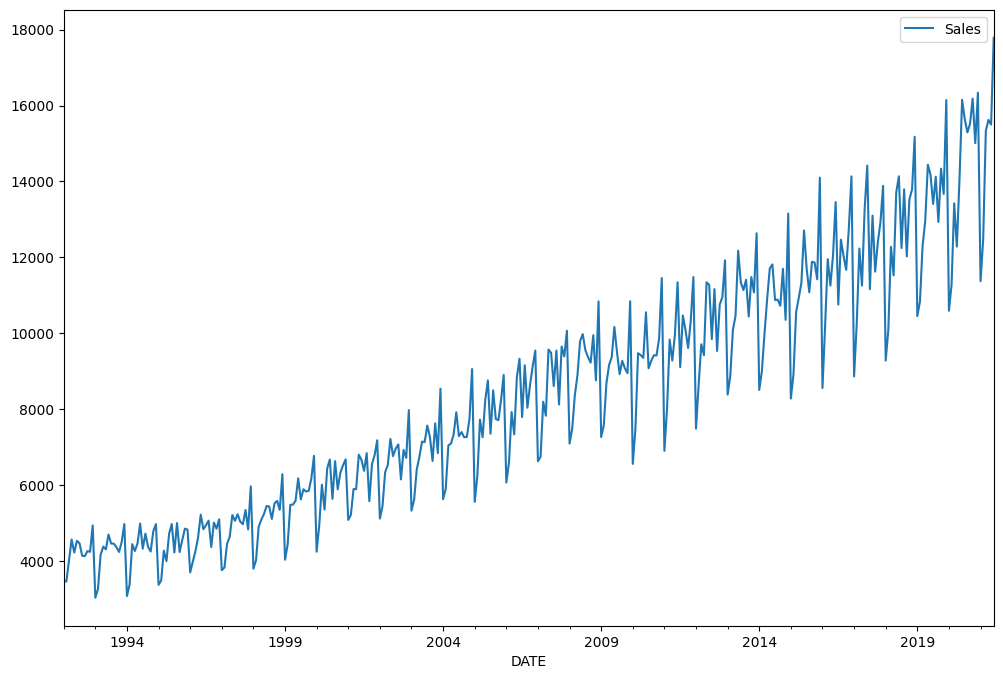

In [142]:
df.plot(figsize=(12,8))

In [143]:
print(df.index.min())
print(df.index.max())

1992-01-01 00:00:00
2021-06-01 00:00:00


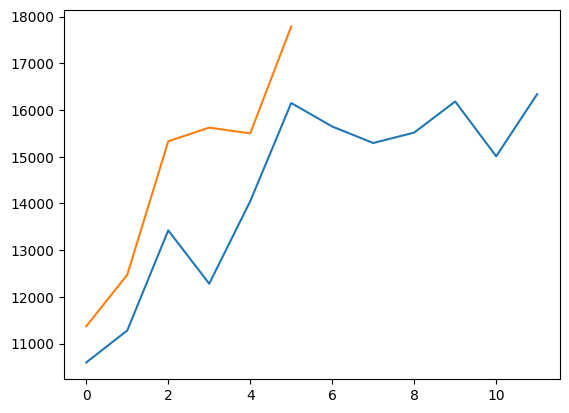

In [144]:
# comparando los ultimos años
verano1992 = df['2020-01-01':'2020-12-31']
plt.plot(verano1992.values)
verano2021 = df['2021-01-01':'2021-06-21']
plt.plot(verano2021.values)

<Axes: xlabel='DATE'>

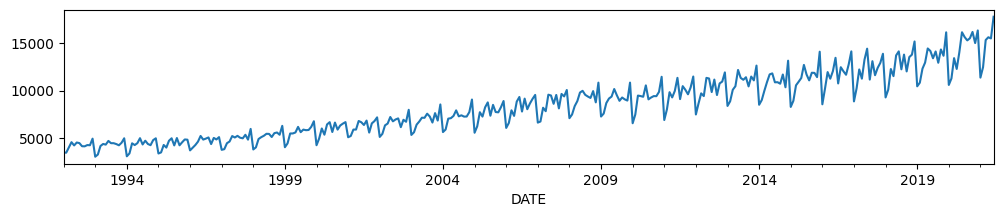

In [145]:
# descomposicion
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

<Axes: xlabel='DATE'>

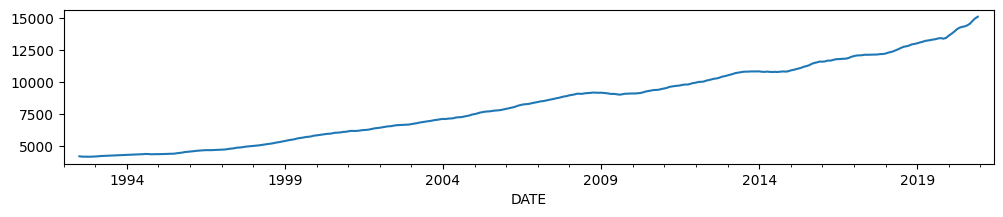

In [146]:
# tendencia
results.trend.plot(figsize=(12,2))

<Axes: xlabel='DATE'>

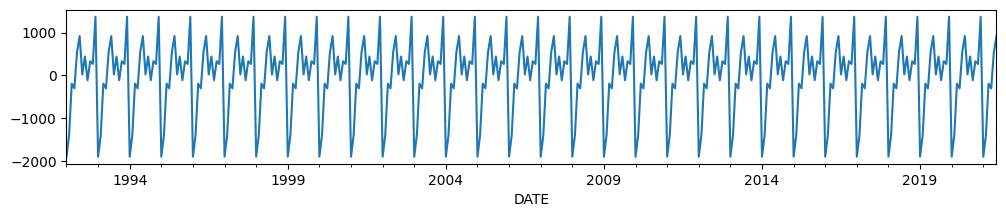

In [147]:
# estacionalidad
results.seasonal.plot(figsize=(12,2))

<Axes: xlabel='DATE'>

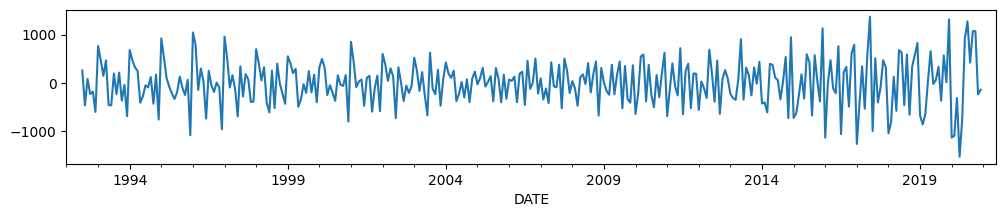

In [148]:
# graficando los residuos
results.resid.plot(figsize=(12,2))

Train Test Split (dividimos la data en training y test)

In [149]:
len(df)

354

In [150]:
# viendo los ultimos 12 meses
len(df)-12

342

In [151]:
# seleccionando con iloc
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [152]:
len(train)

342

In [153]:
len(test)

12

**Escalando datos:**

Cuando se ejecuta una red neuronal, es necesario escalar los datos o normalizarlos.

Enfoque simple: dividir por el valor maximo.

In [154]:
from sklearn.preprocessing import MinMaxScaler

In [155]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [156]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**Time Series Generator**

Este generador toma una secuencia de puntos de datos (como una serie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.
Las redes neuronales  requieren pre entrenamiento

In [157]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [158]:
# Definimos el generador
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
# en este caso, la data y target son lo mismo

In [159]:
len(scaled_train)

342

In [160]:
len(generator) # n_input = 2

340

In [161]:
# llamando a los primeros datos de la data entrenamiento
scaled_train[:5]

array([[0.03262692],
       [0.03255069],
       [0.07402043],
       [0.11686233],
       [0.09071505]])

In [162]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.03262692],
         [0.03255069]]]),
 array([[0.07402043]]))

In [163]:
# guardando los resultados del batch, el primer array en X y el segundo en y
X,y = generator[0]

In [164]:
# observando X e y
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.03262692 0.03255069]
Predicción: 
 [[0.07402043]]


In [165]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
# podemos tener en cuenta si hay un ciclo
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [166]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [167]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03262692 0.03255069 0.07402043 0.11686233 0.09071505 0.11419424
 0.10939168 0.08431163 0.08347309 0.09361183 0.09216344 0.14522031]
Predict this y: 
 [[0.]]


**Estos valores predeficidos, pasamos a la red neuronal**

**Creando el Modelo**

In [168]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

1, crearemos un modelo secuencial

2, la primera capa es una LSTM con 100 neuronas

3, capa densa de prediccion

4, compilando el modelo, optimizando y solicitando indicadores

In [169]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# 1) se crea un modleo secuencial 2) se añade capas LSTM 100 neuronas (prueba y error)
# Dense, una sola predicccion como neurona

In [170]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [171]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50


<ipython-input-171-bfe64445a7b0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=50)


330/330 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 2/50
330/330 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 3/50
330/330 [==============================] - 2s 7ms/step - loss: 0.0080
Epoch 4/50
330/330 [==============================] - 3s 10ms/step - loss: 0.0076
Epoch 5/50
330/330 [==============================] - 3s 8ms/step - loss: 0.0071
Epoch 6/50
330/330 [==============================] - 2s 7ms/step - loss: 0.0065
Epoch 7/50
330/330 [==============================] - 3s 8ms/step - loss: 0.0050
Epoch 8/50
330/330 [==============================] - 3s 8ms/step - loss: 0.0044
Epoch 9/50
330/330 [==============================] - 2s 7ms/step - loss: 0.0036
Epoch 10/50
330/330 [==============================] - 2s 7ms/step - loss: 0.0028
Epoch 11/50
330/330 [==============================] - 3s 8ms/step - loss: 0.0021
Epoch 12/50
330/330 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 13/50
330/330 [=============

In [172]:
model.history.history.keys()

dict_keys(['loss'])

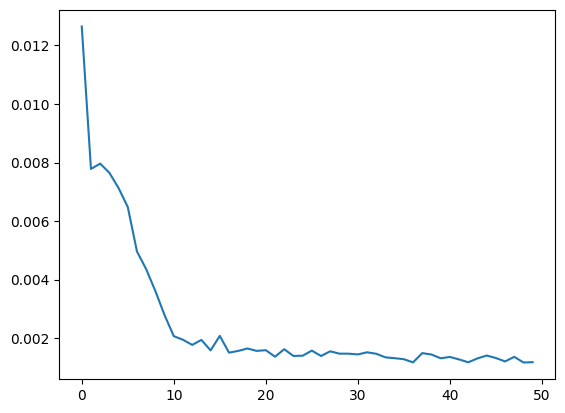

In [173]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

quisa unos 20 era suficiente

Evaluando en los Datos de Prueba (Test)

In [194]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento
# para predecir el 1er mes en el conjunto de prueba
# 12 ultimos datos de los datos de entrenamiento
first_eval_batch = scaled_train[-12:]

In [195]:
first_eval_batch

array([[0.79097423],
       [0.84570819],
       [0.75484068],
       [0.86179296],
       [0.81117548],
       [0.99954261],
       [0.57668852],
       [0.62890685],
       [0.79219393],
       [0.70521421],
       [0.83983839],
       [1.        ]])

In [197]:
# observar los parametros de X
X.shape

(1, 12, 1)

es la dimension de X creada por el generador

In [198]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [199]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 25ms/step


array([[0.83099324]], dtype=float32)

0.83 seria el primer valor predicho de los datos de prueba

In [180]:
# valores reales
scaled_test

array([[0.96165574],
       [0.93474615],
       [0.95174569],
       [1.00251563],
       [0.91309651],
       [1.01448392],
       [0.63576765],
       [0.71977436],
       [0.9375667 ],
       [0.95982619],
       [0.95044976],
       [1.1248666 ]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.

In [200]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]

    # guardar la predicción
    test_predictions.append(current_pred)

    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [201]:
# prediccion para los datos de prueba
test_predictions

[array([0.83099324], dtype=float32),
 array([0.89849603], dtype=float32),
 array([0.8059614], dtype=float32),
 array([0.9156044], dtype=float32),
 array([0.88008684], dtype=float32),
 array([1.0658599], dtype=float32),
 array([0.6139686], dtype=float32),
 array([0.7045254], dtype=float32),
 array([0.83059955], dtype=float32),
 array([0.7596144], dtype=float32),
 array([0.90731364], dtype=float32),
 array([1.0503677], dtype=float32)]

Transformación inversa para comparar los datos originales con las predicciones

In [202]:
true_predictions = scaler.inverse_transform(test_predictions)

In [203]:
true_predictions

array([[13931.96925819],
       [14817.47094464],
       [13603.6012578 ],
       [15041.89868391],
       [14575.97915661],
       [17012.95034957],
       [11085.040236  ],
       [12272.96434319],
       [13926.8048501 ],
       [12995.62180436],
       [14933.14039361],
       [16809.7236588 ]])

In [204]:
test

,Sales,Predictions
DATE,,
2020-07-01,15646,13931.969258
2020-08-01,15293,14817.470945
2020-09-01,15516,13603.601258
2020-10-01,16182,15041.898684
2020-11-01,15009,14575.979157
2020-12-01,16339,17012.950350
2021-01-01,11371,11085.040236
2021-02-01,12473,12272.964343
2021-03-01,15330,13926.804850


In [205]:
# agregando en un solo data frame
test['Predictions'] = true_predictions

<ipython-input-205-b874022161de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [206]:
test

,Sales,Predictions
DATE,,
2020-07-01,15646,13931.969258
2020-08-01,15293,14817.470945
2020-09-01,15516,13603.601258
2020-10-01,16182,15041.898684
2020-11-01,15009,14575.979157
2020-12-01,16339,17012.950350
2021-01-01,11371,11085.040236
2021-02-01,12473,12272.964343
2021-03-01,15330,13926.804850


<Axes: xlabel='DATE'>

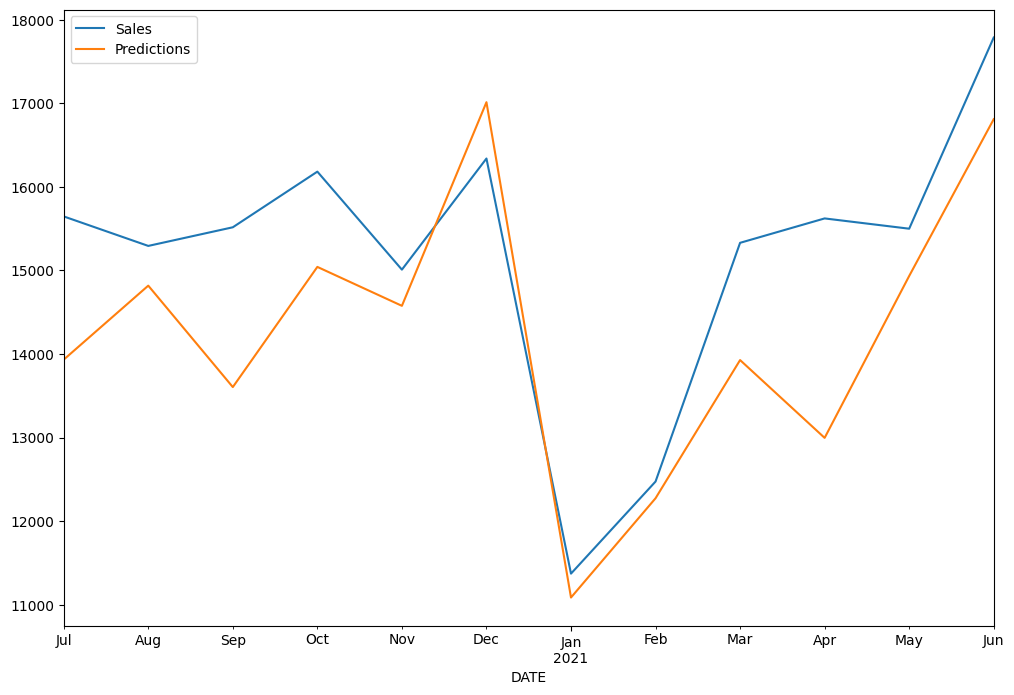

In [207]:

test.plot(figsize=(12,8))

In [209]:
# pronosticando 12 meses siguientes
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(24): # aqui se esta duplicando

    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]

    # guardar la predicción
    test_predictions.append(current_pred)

    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 27ms/step


In [210]:
# prediccion para los datos de prueba
test_predictions

[array([0.83099324], dtype=float32),
 array([0.89849603], dtype=float32),
 array([0.8059614], dtype=float32),
 array([0.9156044], dtype=float32),
 array([0.88008684], dtype=float32),
 array([1.0658599], dtype=float32),
 array([0.6139686], dtype=float32),
 array([0.7045254], dtype=float32),
 array([0.83059955], dtype=float32),
 array([0.7596144], dtype=float32),
 array([0.90731364], dtype=float32),
 array([1.0503677], dtype=float32),
 array([0.87478745], dtype=float32),
 array([0.95559084], dtype=float32),
 array([0.858309], dtype=float32),
 array([0.9737909], dtype=float32),
 array([0.9458565], dtype=float32),
 array([1.1348542], dtype=float32),
 array([0.6586107], dtype=float32),
 array([0.77496815], dtype=float32),
 array([0.869605], dtype=float32),
 array([0.82025427], dtype=float32),
 array([0.9717309], dtype=float32),
 array([1.1031772], dtype=float32)]

In [212]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[13931.96925819],
       [14817.47094464],
       [13603.6012578 ],
       [15041.89868391],
       [14575.97915661],
       [17012.95034957],
       [11085.040236  ],
       [12272.96434319],
       [13926.8048501 ],
       [12995.62180436],
       [14933.14039361],
       [16809.7236588 ],
       [14506.46176696],
       [15566.44069362],
       [14290.29708064],
       [15805.18881655],
       [15438.74571908],
       [17918.01736283],
       [11670.65518308],
       [13197.03215599],
       [14438.4784528 ],
       [13791.09546483],
       [15778.16578734],
       [17502.47837615]])

In [ ]:
# graficar...

**Red LSTM para Regresión**

El problema es el de los pasajeros de las aerolíneas internacionales, el cual es un problema de predicción. Podemos decir que el problema es una regresión como se hizo en el capítulo anterior. Es decir, dado el número de pasajeros (en unidades de miles) este mes, ¿cuál es el número de pasajeros del próximo mes? Este ejemplo reutiliza la misma carga y preparación de datos del capítulo anterior, especialmente el uso de la función create_dataset().

Las LSTMs son sensibles a la escala de los datos de entrada, especialmente cuando se utilizan las funciones de activación sigmoide (por defecto) o tanh. Puede ser una buena práctica reescalar los datos al rango de 0 a 1, también llamado normalización. Podemos normalizar fácilmente el conjunto de datos utilizando la clase de preprocesamiento MinMaxScaler de la biblioteca scikit-learn.

# normalizacion de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz específica en forma de: [muestras, pasos de tiempo, características]. Nuestros datos preparados están en la forma: [muestras, características] y estamos enmarcando el problema como un paso de tiempo para cada muestra. Podemos transformar los datos de entrada del entrenamiento preparado y de la prueba en la estructura esperada utilizando numpy.reshape() de la siguiente manera:

# cambiar la forma de la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

La red tiene una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM o neuronas y una capa de salida que hace una sola predicción de valor. La función de activación sigmoide por defecto se utiliza para los bloques de memoria LSTM. La red está entrenada para 100 épocas y se utiliza un tamaño de lote de 1.

# creacion de la red LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [223]:
# LSTM  para predecir a los pasajeros de las aerolíneas internacionales
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

# semilla aleatoria para reproducibilidad
numpy.random.seed(7)

# cargamos el conjunto de datos
dataframe = read_csv('airline_passengers.csv', usecols=[1], engine='python',skipfooter=3)

In [224]:
dataframe

,Thousands of Passengers
0,112
1,118
2,132
3,129
4,121
...,...
136,472
137,535
138,622
139,606


In [225]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [226]:
dataset

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [ ]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# dividimos entre entranmiento y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# remodelamos X=t y Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#creamos la LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculamos el error rms
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))

# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))

# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

**LSTM para Regresión Usando el Método de la Ventana**

También podemos formular el problema de manera que se puedan utilizar múltiples pasos recientes para hacer la predicción para el próximo paso temporal. Esto se denomina ventana y el tamaño de la ventana es un parametro que se puede ajustar para cada problema. Por ejemplo, dada la hora actual (t) queremos predecir el valor la próxima secuencia (t+1), podemos usar el tiempo actual (t) así como los dos tiempos anteriores (t-1 y t-2) como variables de entrada. De esta forma las variables de entrada son t-2, t-1, t y la variable de salida es t+1.
La función create_dataset() que creamos en la sección anterior nos permite crear esta función para la formulación del problema de las series temporales aumentando el argumento de look_back hacia atrás de 1 a 3. El conjunto de datos con esta formulación tiene el siguiente aspecto:

Epoch 1/100
90/90 - 2s - loss: 0.0235 - 2s/epoch - 22ms/step
Epoch 2/100
90/90 - 0s - loss: 0.0091 - 164ms/epoch - 2ms/step
Epoch 3/100
90/90 - 0s - loss: 0.0072 - 164ms/epoch - 2ms/step
Epoch 4/100
90/90 - 0s - loss: 0.0062 - 156ms/epoch - 2ms/step
Epoch 5/100
90/90 - 0s - loss: 0.0053 - 161ms/epoch - 2ms/step
Epoch 6/100
90/90 - 0s - loss: 0.0047 - 173ms/epoch - 2ms/step
Epoch 7/100
90/90 - 0s - loss: 0.0041 - 167ms/epoch - 2ms/step
Epoch 8/100
90/90 - 0s - loss: 0.0037 - 158ms/epoch - 2ms/step
Epoch 9/100
90/90 - 0s - loss: 0.0034 - 166ms/epoch - 2ms/step
Epoch 10/100
90/90 - 0s - loss: 0.0033 - 153ms/epoch - 2ms/step
Epoch 11/100
90/90 - 0s - loss: 0.0031 - 158ms/epoch - 2ms/step
Epoch 12/100
90/90 - 0s - loss: 0.0030 - 161ms/epoch - 2ms/step
Epoch 13/100
90/90 - 0s - loss: 0.0030 - 215ms/epoch - 2ms/step
Epoch 14/100
90/90 - 0s - loss: 0.0030 - 234ms/epoch - 3ms/step
Epoch 15/100
90/90 - 0s - loss: 0.0029 - 239ms/epoch - 3ms/step
Epoch 16/100
90/90 - 0s - loss: 0.0027 - 236ms/epoc

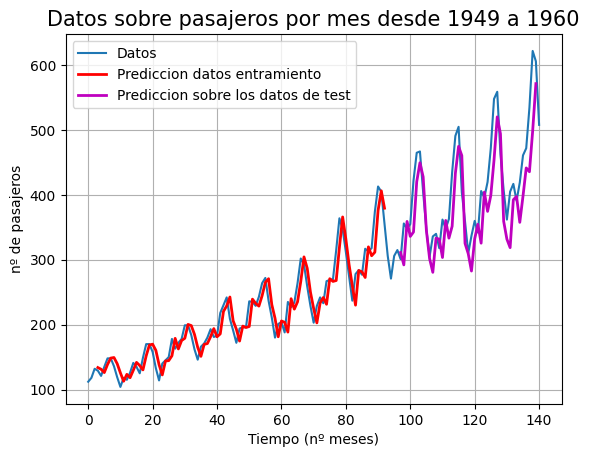

In [219]:
# LSTM para predecir a los pasajeros de las aerolíneas internacionales con ventanas de regresion
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)
# cargamos el conjunto de datos
dataframe = read_csv('airline_passengers.csv', usecols=[1], engine='python',skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# dividimos entre entranmiento y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# remodelamos X=t y Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# creamos la LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculamos el error rms
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

LSTM para Regresión con Pasos de Tiempo
**texto en negrita**
Es posible que haya notado que la preparación de datos para la red LSTM incluye pasos de tiempo. Algunos problemas de secuencia pueden tener un número variado de pasos de tiempo por muestra. Por ejemplo, puede tener mediciones de una máquina física que conducen a un punto de falla o a un punto de sobrecarga. Cada incidente sería una muestra, las observaciones que conducen al evento serían los pasos temporales y las variables observadas serían las características. Los pasos de tiempo proporcionan otra manera de expresar nuestro problema de series de tiempo. Como en el ejemplo de la ventana anterior, podemos tomar pasos temporales previos en nuestra serie temporal como entradas para predecir la salida en el siguiente paso de tiempo.

En lugar de formular las observaciones pasadas como características de entrada separadas, podemos usarlas como pasos de tiempo de la característica de una entrada, que de hecho es un marco más preciso del problema.

Epoch 1/100
90/90 - 2s - loss: 0.0385 - 2s/epoch - 22ms/step
Epoch 2/100
90/90 - 0s - loss: 0.0135 - 182ms/epoch - 2ms/step
Epoch 3/100
90/90 - 0s - loss: 0.0112 - 185ms/epoch - 2ms/step
Epoch 4/100
90/90 - 0s - loss: 0.0092 - 169ms/epoch - 2ms/step
Epoch 5/100
90/90 - 0s - loss: 0.0080 - 186ms/epoch - 2ms/step
Epoch 6/100
90/90 - 0s - loss: 0.0066 - 186ms/epoch - 2ms/step
Epoch 7/100
90/90 - 0s - loss: 0.0056 - 175ms/epoch - 2ms/step
Epoch 8/100
90/90 - 0s - loss: 0.0049 - 189ms/epoch - 2ms/step
Epoch 9/100
90/90 - 0s - loss: 0.0044 - 175ms/epoch - 2ms/step
Epoch 10/100
90/90 - 0s - loss: 0.0042 - 190ms/epoch - 2ms/step
Epoch 11/100
90/90 - 0s - loss: 0.0039 - 183ms/epoch - 2ms/step
Epoch 12/100
90/90 - 0s - loss: 0.0038 - 194ms/epoch - 2ms/step
Epoch 13/100
90/90 - 0s - loss: 0.0037 - 188ms/epoch - 2ms/step
Epoch 14/100
90/90 - 0s - loss: 0.0037 - 193ms/epoch - 2ms/step
Epoch 15/100
90/90 - 0s - loss: 0.0035 - 176ms/epoch - 2ms/step
Epoch 16/100
90/90 - 0s - loss: 0.0037 - 201ms/epoc

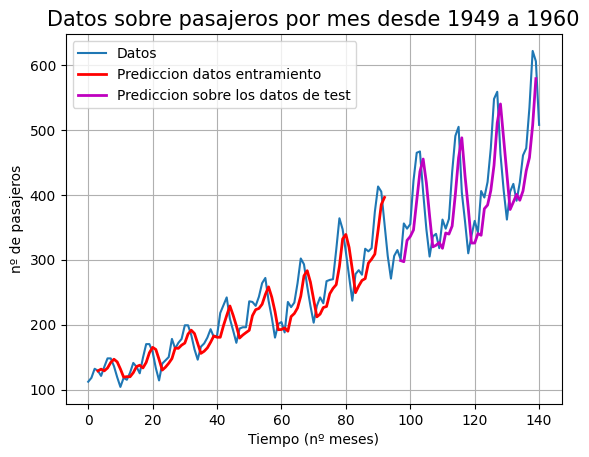

In [220]:
# LSTM  para predecir a los pasajeros de las aerolíneas internacionales con ventanas de regresion
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)
# cargamos el conjunto de datos
dataframe = read_csv('airline_passengers.csv', usecols=[1], engine='python',skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# dividimos entre entranmiento y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# remodelamos X=t y Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# creamos la LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculamos el error rms
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

LSTM con memoria entre Lotes
**texto en negrita**
La red LSTM tiene una memoria que es capaz de recordar a través de largas secuencias. Normalmente, el estado dentro de la red se reajusta después de cada lote de entrenamiento al probar el modelo y cuando llama a model.predict() o model.evaluate(). Podemos obtener el control cuando el estado interno de la red LSTM se borra en Keras haciendo que la capa LSTM sea con estado. Esto significa que puede construir estados a lo largo de toda la secuencia de entrenamiento e incluso mantenerlos si es necesario para hacer predicciones.
Requiere que los datos de formación no se borren cuando se está conectando la red. También requiere restablecimiento explícito del estado de la red después de cada exposición a los datos de entrenamiento (época) mediante llamadas a los estados model.reset(). Esto significa que debemos crear nuestro propio bucle exterior de épocas y dentro de cada época llamar por ejemplo a model.fit() y model.reset states():

90/90 - 2s - loss: 0.0055 - 2s/epoch - 28ms/step
90/90 - 0s - loss: 0.0099 - 282ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0068 - 292ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0055 - 262ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0051 - 195ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0050 - 172ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0050 - 174ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0049 - 185ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0048 - 181ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0048 - 172ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0047 - 179ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0046 - 179ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0046 - 201ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0045 - 180ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0044 - 195ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0044 - 202ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0043 - 185ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0043 - 192ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0042 - 190ms/epoch - 2ms/step
90/90 - 0s - loss: 0.0042 - 190ms

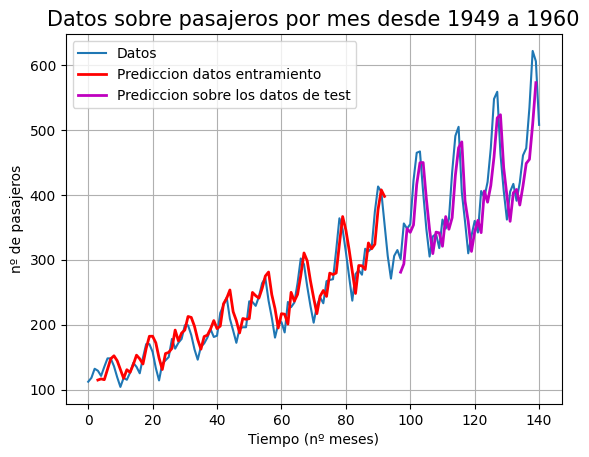

In [221]:
# LSTM para predecir a los pasajeros de las aerolíneas internacionales con memoria entre Lotes
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)
# cargamos el conjunto de datos
dataframe = read_csv('airline_passengers.csv', usecols=[1], engine='python',skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# dividimos entre entranmiento y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# remodelamos X=t y Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# creamos la LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()
# hacemos las predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculamos el error rms
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

LSTMs apiladas con memoria entre lotes
**texto en negrita**
Finalmente, echaremos un vistazo a uno de los grandes beneficios de las LSTM, el cual es el hecho de que puedan ser entrenadas exitosamente cuando se apilan en arquitecturas de red profundas. Las redes LSTM se pueden apilar en Keras de la misma manera que otros tipos de capas se pueden apilar. Una adición a la configuración que se requiere es que una capa LSTM antes de cada capa LSTM posterior deba devolver la secuencia. Esto se puede hacer estableciendo el parámetro de secuencias de retorno o return_sequences en la capa True. Podemos extender la LSTM con estado en la sección anterior para tener dos capas, de la siguiente manera:

90/90 - 4s - loss: 0.0048 - 4s/epoch - 39ms/step
90/90 - 0s - loss: 0.0086 - 286ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0066 - 288ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0059 - 318ms/epoch - 4ms/step
90/90 - 0s - loss: 0.0059 - 319ms/epoch - 4ms/step
90/90 - 0s - loss: 0.0059 - 283ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0059 - 295ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0059 - 283ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0059 - 310ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0059 - 435ms/epoch - 5ms/step
90/90 - 0s - loss: 0.0058 - 397ms/epoch - 4ms/step
90/90 - 0s - loss: 0.0058 - 474ms/epoch - 5ms/step
90/90 - 0s - loss: 0.0057 - 458ms/epoch - 5ms/step
90/90 - 0s - loss: 0.0057 - 284ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0056 - 285ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0056 - 274ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0056 - 288ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0055 - 301ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0055 - 286ms/epoch - 3ms/step
90/90 - 0s - loss: 0.0054 - 312ms

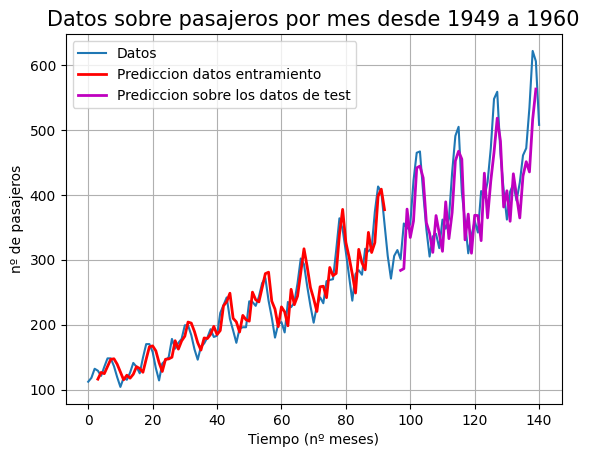

In [222]:
#LSTMs apiladas con memoria entre lotes para predecir a los pasajeros de las aerolíneas internacionales
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convertimos un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)
# semilla aleatoria para reproducibilidad
numpy.random.seed(7)
# cargamos el conjunto de datos
dataframe = read_csv('airline_passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# dividimos entre entranmiento y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# remodelamos X=t y Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# creamos la LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()
# hacemos las predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculamos el error rms
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

In [ ]:
# https://github.com/jcasasr/Libro-Deep-Learning/blob/main/cap10/C10_E1_Ejemplo-series-temporales-RNN.ipynb
